<a href="https://colab.research.google.com/github/Juanezm/uoc-data-science-tfm/blob/main/notebooks/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output
from IPython.display import HTML
from sklearn.model_selection import train_test_split
import scipy.stats as stats

# Load data
sensor_ids = [
    '200034001951343334363036',
    '270043001951343334363036',
    '380033001951343334363036',
    '46004e000251353337353037',
    '46005a000351353337353037',
    '4e0022000251353337353037',
    '4e0031000251353337353037',
]
datasets = [pd.read_csv(f'../src/data_cleaning/{id}_cleaned_data.csv', usecols =['date', 'Barometric pressure', 'Battery', 'Humidity', 'Rain meter', 'Soil moisture', 'Temperature', 'Wind speed']) for id in sensor_ids]

display(datasets[0])

,date,Barometric pressure,Battery,Humidity,Rain meter,Soil moisture,Temperature,Wind speed
0,2018-04-12 19:27:00,990.35,83.52,42.26,0.0,28.05,21.60,6.23
1,2018-04-12 19:37:00,990.45,83.03,43.93,0.0,27.25,20.59,14.55
2,2018-04-12 19:47:00,990.44,83.03,46.39,0.0,28.71,20.29,6.23
3,2018-04-12 19:57:00,990.33,82.38,49.45,0.0,28.15,19.47,8.31
4,2018-04-12 20:07:00,990.28,81.89,51.66,0.0,27.88,18.80,8.31
...,...,...,...,...,...,...,...,...
21840,2018-09-14 15:00:00,1010.68,95.92,45.45,0.0,17.11,26.03,0.00
21841,2018-09-14 15:02:00,1010.59,97.66,45.07,0.0,17.55,26.31,0.00
21842,2018-09-14 15:03:00,1010.54,97.18,44.93,0.0,17.41,26.32,0.00
21843,2018-09-14 17:27:00,1010.54,87.35,49.68,0.0,17.53,29.59,0.00


In [ ]:
df = datasets[0]

df.describe()

,Barometric pressure,Battery,Humidity,Rain meter,Soil moisture,Temperature,Wind speed
count,21845.000000,21845.000000,21845.000000,21845.000000,21845.000000,21845.000000,21845.000000
mean,1004.919136,68.263869,54.505188,0.015333,20.851421,27.753586,3.307523
std,3.389382,13.935326,14.983469,0.136196,5.875802,7.579918,3.072518
min,990.280000,6.610000,11.470000,0.000000,0.070000,9.880000,0.000000
25%,1002.630000,58.210000,42.720000,0.000000,16.970000,22.390000,2.080000
50%,1004.980000,70.450000,56.450000,0.000000,17.600000,26.810000,2.080000
75%,1006.980000,81.730000,66.430000,0.000000,24.980000,33.770000,4.160000
max,1015.220000,97.660000,80.000000,2.550000,35.770000,45.990000,35.330000


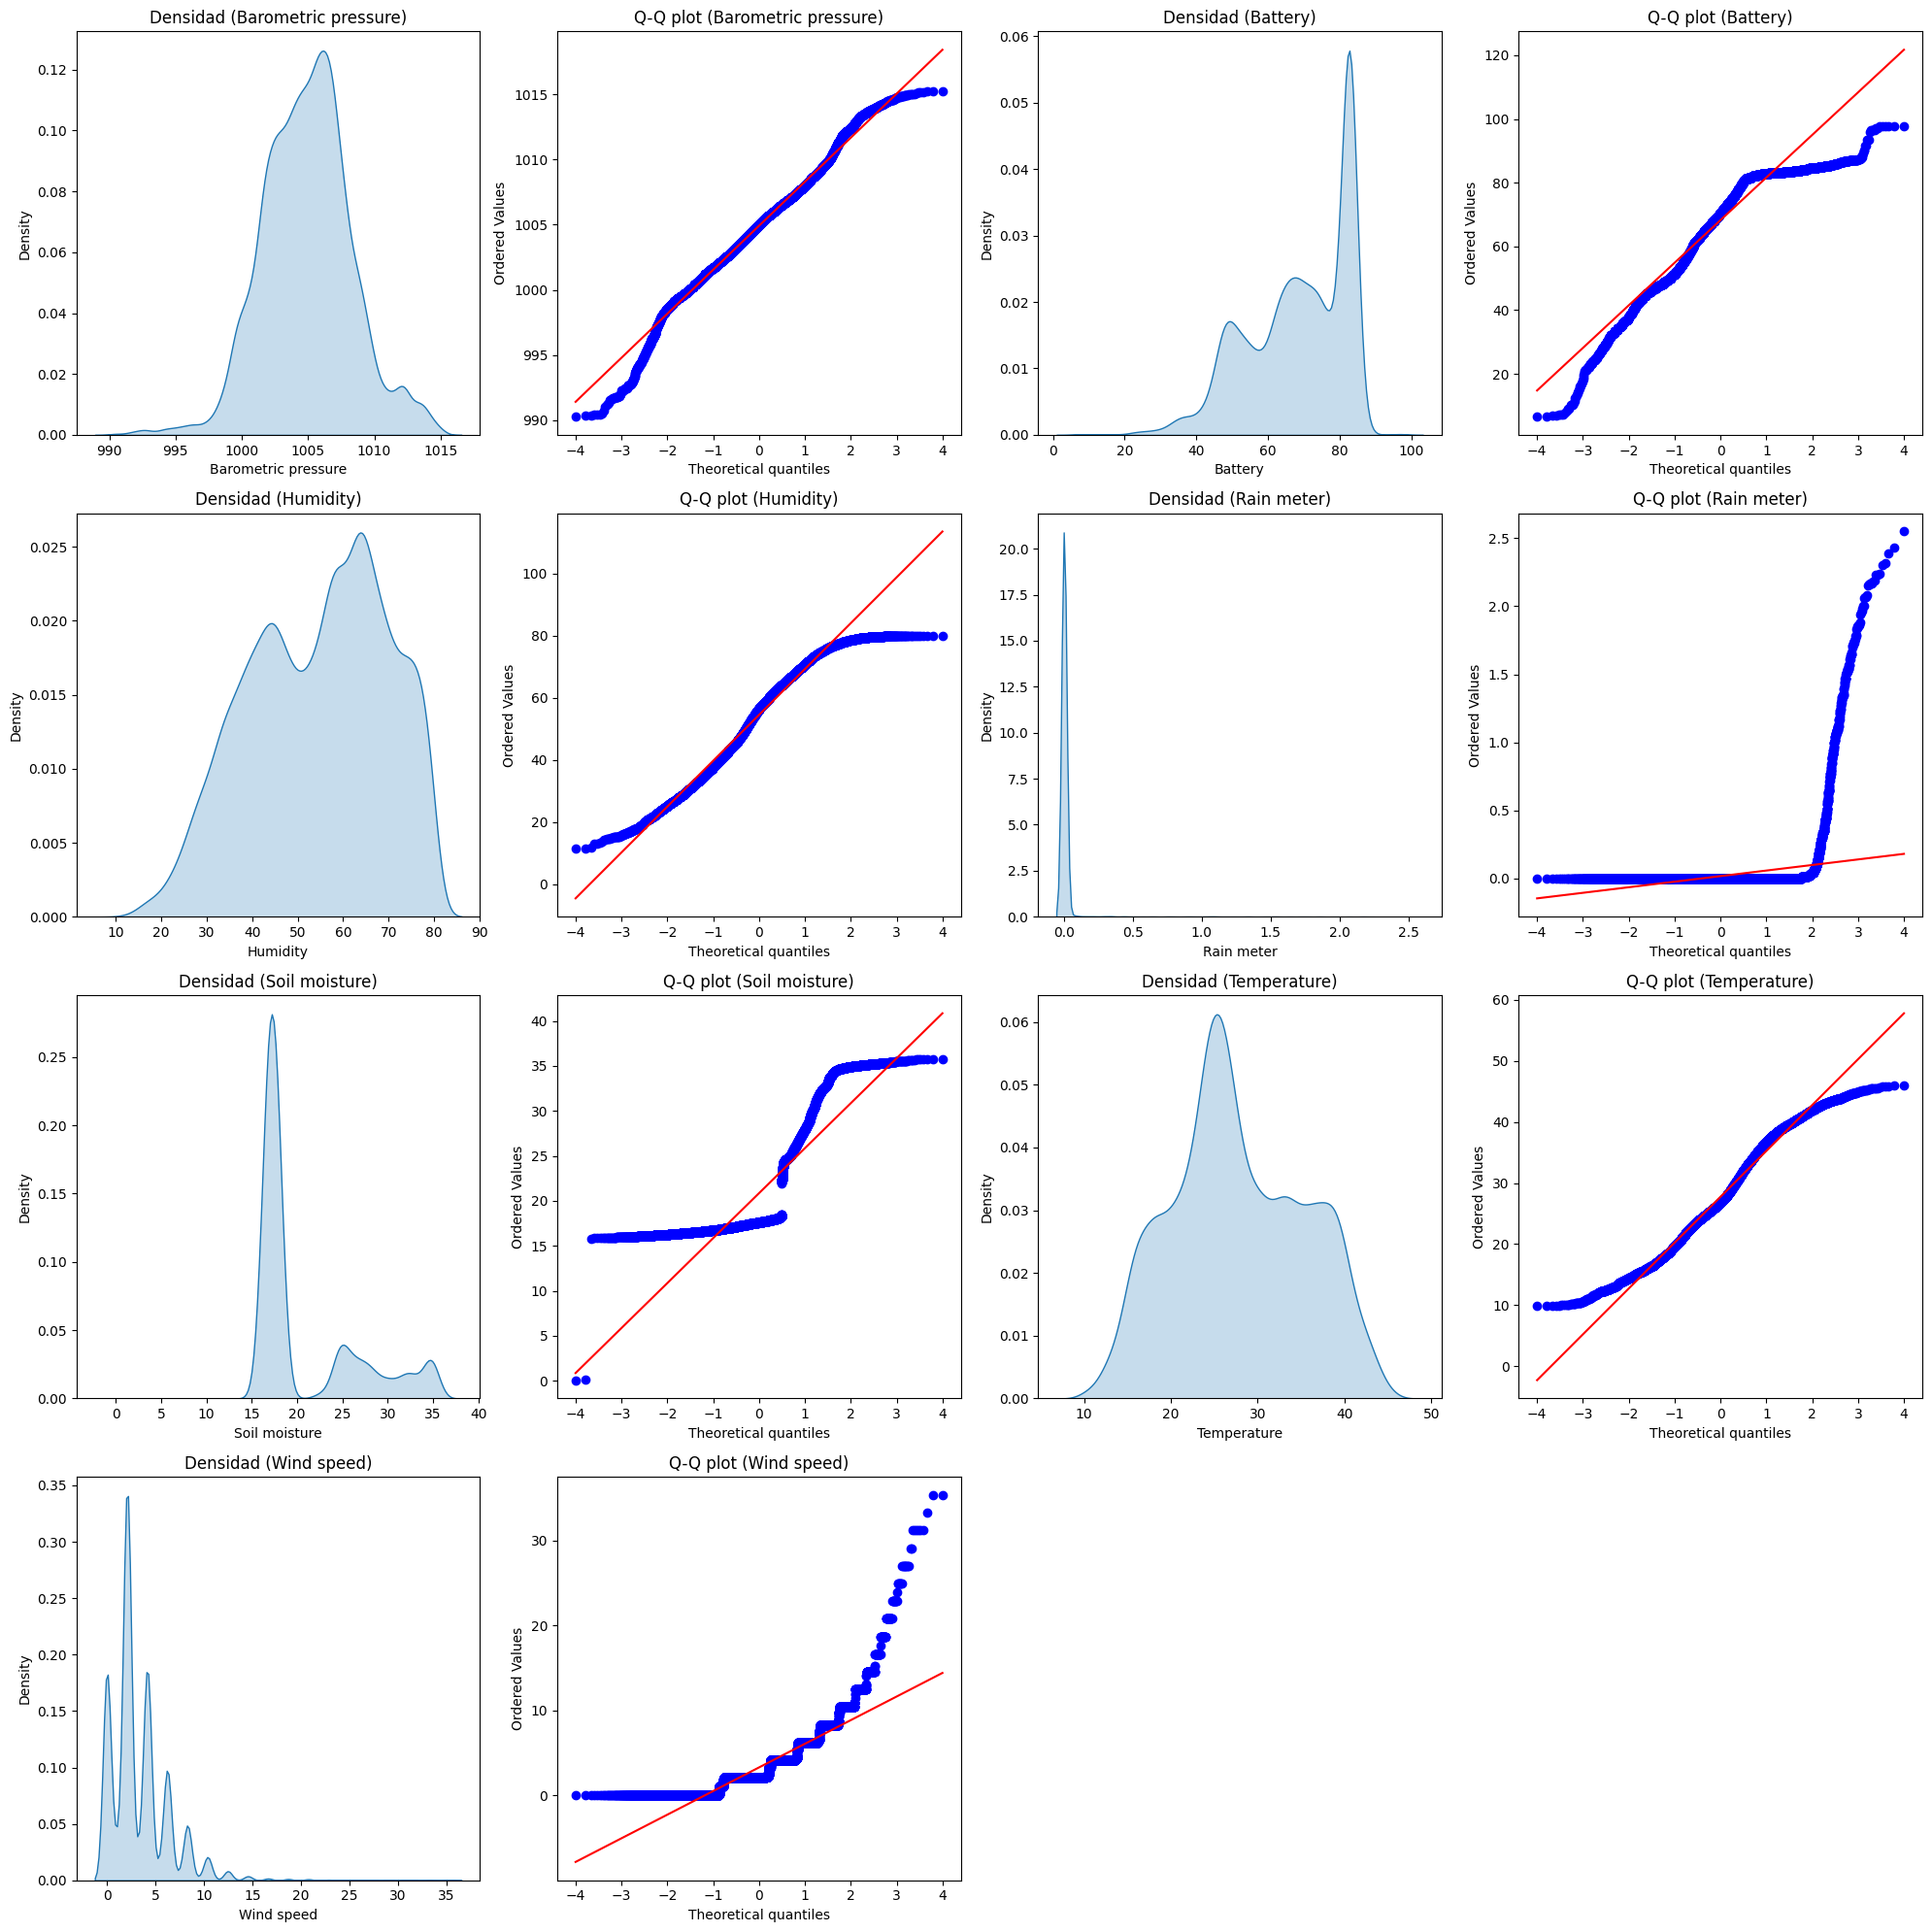

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# Seleccionar columnas numéricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Crear un par de subplots para cada par de columnas numéricas
fig, axs = plt.subplots(nrows=(len(num_cols)+1)//2, ncols=4, figsize=(20, 5*((len(num_cols)+1)//2)))

# Iterar sobre todas las columnas numéricas
for i, column in enumerate(num_cols):
    row = i // 2
    col = (i % 2) * 2
    # Si la columna es numérica, hacer el Q-Q plot y la gráfica de densidad
    sns.kdeplot(df[column], ax=axs[row, col], fill=True)
    axs[row, col].set_title(f'Densidad ({column})')

    probplot(df[column].dropna(), plot=axs[row, col+1])
    axs[row, col+1].set_title(f'Q-Q plot ({column})')

    # Si es la última variable y el número de variables es impar, desactivar el último par de gráficos
    if (i == len(num_cols) - 1) and (len(num_cols) % 2 != 0):
        fig.delaxes(axs[row, col+2])
        fig.delaxes(axs[row, col+3])

# Ajustar el espaciado
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.stats.diagnostic import lilliefors
from tabulate import tabulate

# Seleccionar columnas numéricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Lista para guardar los resultados
results = []

# Iterar sobre todas las columnas numéricas
for column in num_cols:
    # Realizar la prueba de Lilliefors
    lillie_stat, lillie_p = lilliefors(df[column].dropna())

    # Añadir los resultados a la lista
    results.append([column, lillie_stat, lillie_p])

# Crear una tabla con los resultados
table = tabulate(results, headers=['Variable', 'Lilliefors Statistic', 'Lilliefors p-value'], tablefmt='latex', floatfmt=".3f")

# Imprimir la tabla
print(table)


\begin{tabular}{lrr}
\hline
 Variable            &   Lilliefors Statistic &   Lilliefors p-value \\
\hline
 Barometric pressure &                  0.026 &                0.001 \\
 Battery             &                  0.119 &                0.001 \\
 Humidity            &                  0.060 &                0.001 \\
 Rain meter          &                  0.506 &                0.001 \\
 Soil moisture       &                  0.357 &                0.001 \\
 Temperature         &                  0.052 &                0.001 \\
 Wind speed          &                  0.223 &                0.001 \\
\hline
\end{tabular}


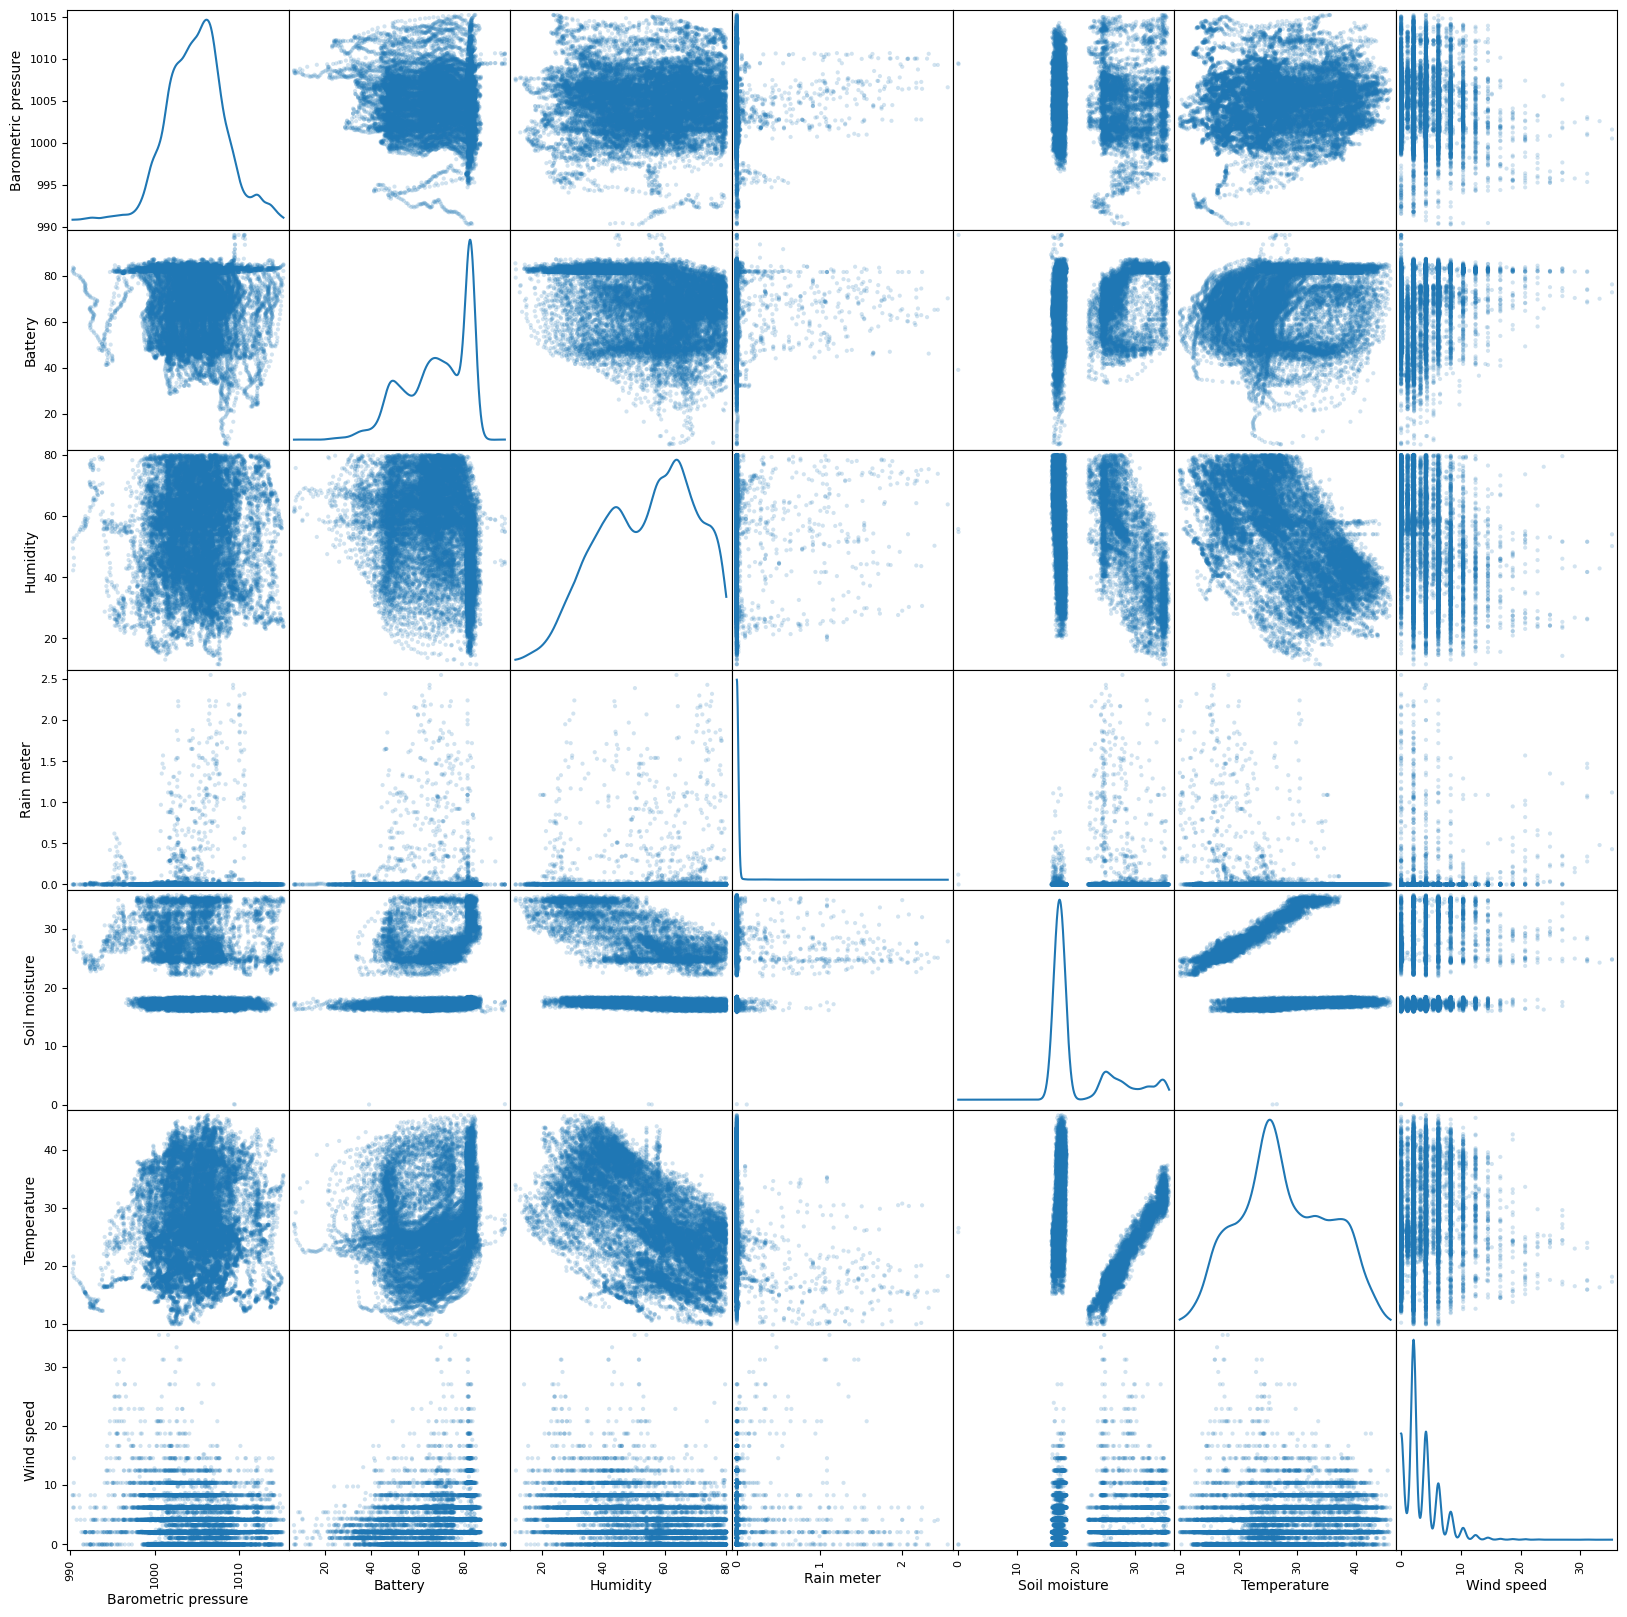

In [ ]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Seleccionar columnas numéricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Crear la matriz de gráficos de dispersión
scatter_matrix(df[num_cols], alpha=0.2, figsize=(20, 20), diagonal='kde')

# Mostrar el gráfico
plt.show()


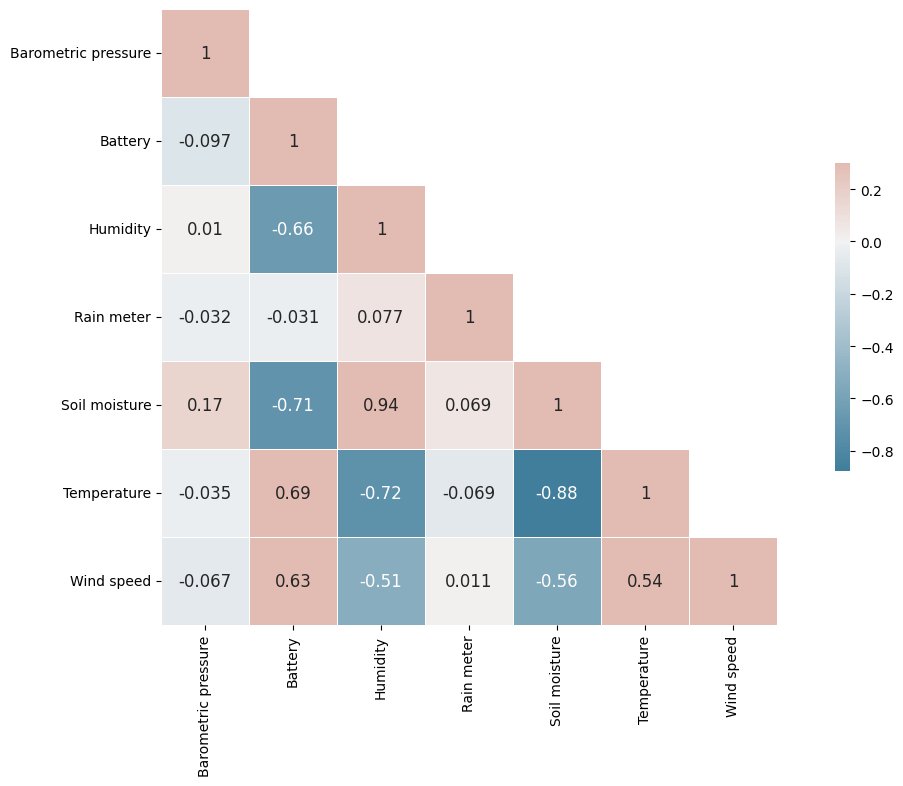

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame df
# Calcular la matriz de correlación
corr = df.corr(method='spearman', numeric_only=True)

# Crear una máscara para el triángulo superior de la matriz de correlación
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Crear una paleta de colores divergente para resaltar las correlaciones positivas y negativas
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Specify size of heatmap
fig, ax = plt.subplots(figsize=(15, 8))

# Dibujar el mapa de calor
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":12})

# Mostrar el gráfico
plt.show()



In [ ]:
from scipy.stats import kruskal, mannwhitneyu
from tabulate import tabulate

# Lista para guardar los resultados
results = []

# Comparar todos los pares de nodos usando Kruskal-Wallis
for i in range(len(datasets)):
    for j in range(i+1, len(datasets)):
        node1 = datasets[i]['Battery']
        node2 = datasets[j]['Battery']
        h_statistic, p_value = kruskal(node1, node2)

        # Obtener los IDs de los nodos
        node1_id = sensor_ids[i]
        node2_id = sensor_ids[j]

        # Determinar si hay diferencias significativas
        if p_value < 0.05:
            result = "Significativas"
        else:
            result = "No significativas"

        # Agregar los resultados a la lista
        results.append([node1_id, node2_id, h_statistic, p_value, result])

# # Comparar todos los pares de nodos usando Mann-Whitney U
# for i in range(len(datasets)):
#     for j in range(i+1, len(datasets)):
#         node1 = datasets[i]['Battery']
#         node2 = datasets[j]['Battery']
#         u_statistic, p_value = mannwhitneyu(node1, node2)

#         # Obtener los IDs de los nodos
#         node1_id = sensor_ids[i]
#         node2_id = sensor_ids[j]

#         # Determinar si hay diferencias significativas
#         if p_value < 0.05:
#             result = "Sí"
#         else:
#             result = "No"

#         # Agregar los resultados a la lista
#         results.append([node1_id, node2_id, u_statistic, p_value, result])

# Ordenar los resultados por el valor p
results_sorted = sorted(results, key=lambda x: x[3], reverse=True)  # Ordenar por el valor p (columna 3)

# Crear una tabla con los resultados ordenados
table = tabulate(results_sorted, headers=['Nodo 1', 'Nodo 2', 'Estadístico', 'Valor p', 'Diferencias'], tablefmt='latex', floatfmt=".3f")

# Imprimir la tabla ordenada
print(table)


\begin{tabular}{llrrl}
\hline
 Nodo 1                   & Nodo 2                   &   Estadístico &   Valor p & Diferencias       \\
\hline
 270043001951343334363036 & 46004e000251353337353037 &         1.910 &     0.167 & No significativas \\
 200034001951343334363036 & 4e0031000251353337353037 &         5.818 &     0.016 & Significativas    \\
 46004e000251353337353037 & 46005a000351353337353037 &        49.083 &     0.000 & Significativas    \\
 200034001951343334363036 & 380033001951343334363036 &        85.921 &     0.000 & Significativas    \\
 46004e000251353337353037 & 4e0031000251353337353037 &       105.278 &     0.000 & Significativas    \\
 200034001951343334363036 & 46004e000251353337353037 &       123.625 &     0.000 & Significativas    \\
 270043001951343334363036 & 46005a000351353337353037 &       124.510 &     0.000 & Significativas    \\
 270043001951343334363036 & 4e0031000251353337353037 &       125.953 &     0.000 & Significativas    \\
 380033001951343334363036 &

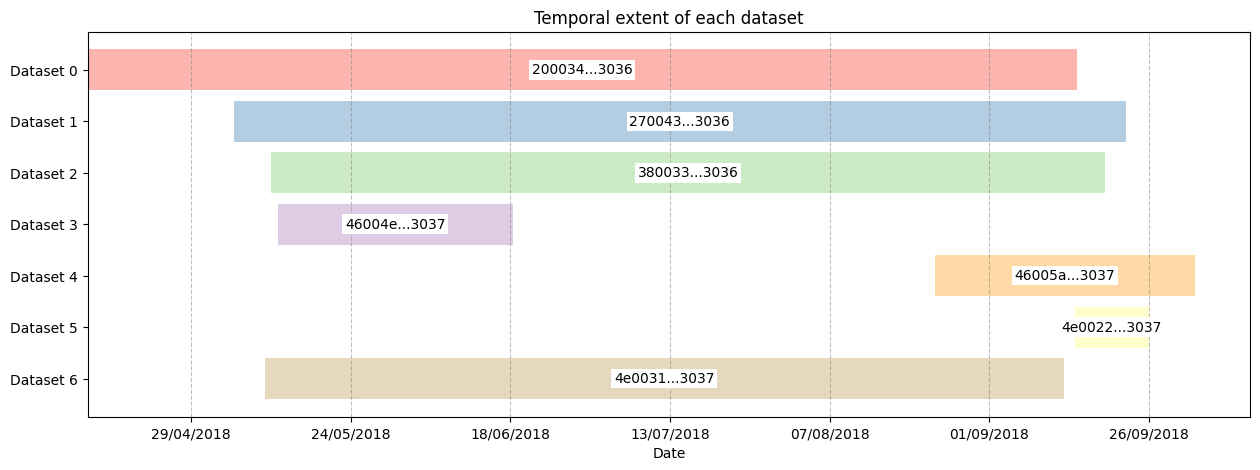

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib

nodes_ids_red = [
    '200034...3036',
    '270043...3036',
    '380033...3036',
    '46004e...3037',
    '46005a...3037',
    '4e0022...3037',
    '4e0031...3037',
]

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(15, 5))

# Usar la paleta de colores 'Pastel1'
cmap = matplotlib.colormaps.get_cmap('Pastel1')

# Por cada dataframe en la lista
for i, df in enumerate(datasets):
    # Convertir la columna 'date' a datetime si aún no lo es
    df['date'] = pd.to_datetime(df['date'])

    # Encontrar la fecha mínima y máxima en el dataframe
    min_date = df['date'].min()
    max_date = df['date'].max()

    # Dibujar una barra en la posición i con longitud desde min_date hasta max_date
    ax.barh(i, max_date - min_date, left=min_date, color=cmap(i % cmap.N))

    # Calcular la posición x del centro de la barra
    bar_center_x = min_date + (max_date - min_date) / 2

    # Agregar una etiqueta encima de cada barra con el ID del sensor correspondiente
    ax.annotate(nodes_ids_red[i], xy=(bar_center_x, i), xytext=(0, 0), textcoords="offset points", fontsize=10, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', pad=2))


# Configurar las etiquetas del eje y para representar el índice del dataframe en la lista
ax.set_yticks(range(len(datasets)))
ax.set_yticklabels(['Dataset {}'.format(i) for i in range(len(datasets))])

# Invertir el eje y para que el dataset 0 esté en la parte superior
ax.invert_yaxis()

# Establecer el formato de las fechas en el eje x como día y mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

# Añadir gridlines
ax.grid(True, axis='x', linestyle='--', color='gray', alpha=0.5)

# Etiquetas de los ejes y título
ax.set_xlabel('Date')
ax.set_title('Temporal extent of each dataset')

# Mostrar el gráfico
plt.show()

